# About

Script to generate the figures pertaining to large-N dimensional analysis. Includes plotting the synchronous frequencies and Gaussian variance and their corresponding eigenvalue distributions and patterns. Import .mat files generated from 'sec4_ND_analysis.m'.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec4_ND_analysis7'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)

# Import

## Parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

# Parameters
g = dict_mat['g'][0,0]
w0 = dict_mat['omega0'][0,0]
gain = dict_mat['gain'][0,0]
tau0 = dict_mat['tau0'][0,0]
scale = 1
tol = dict_mat['logtol'][0,0]

## Theoretical frequencies

In [4]:
parameters = {'g': g, 'omega0': w0, 'gain': gain, 'tau0': tau0}
L = pi
steps = 100

# Choose deltas
delta1 = 0.05
delta2 = 0.10
delta3 = 0.15
delta4 = 0.20

freqarr = np.linspace(w0-g, w0+g, num=100)
errarr1 = np.zeros(freqarr.size)
errarr2 = np.zeros(freqarr.size)
errarr3 = np.zeros(freqarr.size)
errarr4 = np.zeros(freqarr.size)

for i in range(len(freqarr)):
    freq = freqarr[i]
    errarr1[i] = funlib.Omega_infty(freq, delta1, parameters, L=L, steps=steps) - freq
    errarr2[i] = funlib.Omega_infty(freq, delta2, parameters, L=L, steps=steps) - freq
    errarr3[i] = funlib.Omega_infty(freq, delta3, parameters, L=L, steps=steps) - freq
    errarr4[i] = funlib.Omega_infty(freq, delta4, parameters, L=L, steps=steps) - freq

## Compile arrays

In [5]:
# Chosen deltas
delta_eig1 = 0.03
delta_eig2 = 0.2

# Tolerance for zero
tolzero = 0.001

# Maximum allowed log10 error
MAXERR = -3

# Distance from chosen deltas
DIST1 = 100
DIST2 = 100

deltaarr = np.array([])
Omegaarr = np.array([])
leadreeigs = np.array([])
maxerrors = np.array([])

for i in range(len(filenames)):
    
    # Get file dict
    dir_file = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_file)
    
    # Acquire data
    delta = dict_mat['delta'][0,0]
    Omega = dict_mat['Omega'][0,0]
    
    # Scale
    # scale = dict_mat['scale'][0,0]
    
    # Eigenvalues
    eigs = dict_mat['found']
    # print(delta)
    # print(eigs)
    scaled_eigs = eigs
    error = np.max(dict_mat['errors'])
    
    # Filter out eigenvalues with large log10 error
    eigs = eigs[np.log10(error) < MAXERR]
    
    # Leading eigenvalue
    nonzero_eigs = scaled_eigs[np.abs(scaled_eigs) > tolzero]
    if nonzero_eigs.size == 0:
        continue
    
    leadreeig = np.max(np.real(nonzero_eigs))
    
    # Update arrays
    deltaarr = np.append(deltaarr, delta)
    Omegaarr = np.append(Omegaarr, Omega)
    leadreeigs = np.append(leadreeigs, leadreeig)
    maxerrors = np.append(maxerrors, error)
    
    # Check if near chosen delta
    dist1 = np.abs(delta - delta_eig1)
    dist2 = np.abs(delta - delta_eig2)
    
    if dist1 < DIST1:
        u_mesh1 = dict_mat['re']
        v_mesh1 = dict_mat['im']
        f_mesh1 = dict_mat['fvals']
        found_eigs1 = dict_mat['found']
        found_errs1 = dict_mat['errors']
        delta_plot1 = delta
        Omega_plot1 = Omega
        Deltas1 = dict_mat['Delta']
        DIST1 = dist1
    
    if dist2 < DIST2:
        u_mesh2 = dict_mat['re']
        v_mesh2 = dict_mat['im']
        f_mesh2 = dict_mat['fvals']
        found_eigs2 = dict_mat['found']
        found_err2 = dict_mat['errors']
        delta_plot2 = delta
        Omega_plot2 = Omega
        Deltas2 = dict_mat['Delta']
        DIST2 = dist2
        
# Re-order delta
sortinds = np.argsort(deltaarr)
deltaarr = deltaarr[sortinds]
Omegaarr = Omegaarr[sortinds]
leadreeigs = leadreeigs[sortinds]

# Plot

## Eigenvalue plots

Define function to plot each set of meshes and points

In [6]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.10, 0.80, 0.30, 0.20] # Top left (error plot)
bbox1 = [0.10, 0.45, 0.30, 0.20] # Middle left (stability of expected eigenvalues)
bbox2 = [0.10, 0.10, 0.30, 0.20] # Bottom left (stability of actual eigenvalues)
bbox3 = [0.50, 0.10, 0.20, 0.90] # Right eig plot 1
bbox4 = [0.80, 0.10, 0.20, 0.90] # Right eig plot 2

# Alphas
alpha1 = 0.8
alpha_col = 0.2
alpha_w0 = 0.8

col1 = 'orange'
col2 = 'blue'
col_w0 = 'green'

# Linewidths
lw1 = 0.5
lw2 = 1.0

# Markers
m1 = 'x'
m2 = 's'

# Markersize
ms1 = 4

# S.log function
slog = lambda x: np.sign(x)*np.log10(1 + np.abs(x))

## Options

In [7]:
# Plot positions [left, bottom, width, height]
bbox0 = [0.10, 0.80, 0.30, 0.20] # Top left (error plot)
bbox1 = [0.10, 0.45, 0.30, 0.20] # Middle left (stability of expected eigenvalues)
bbox2 = [0.10, 0.10, 0.30, 0.20] # Bottom left (stability of actual eigenvalues)
bbox3 = [0.50, 0.10, 0.20, 0.90] # Right eig plot 1
bbox4 = [0.80, 0.10, 0.20, 0.90] # Right eig plot 2

# Alphas
alpha1 = 0.8
alpha_col = 0.2
alpha_w0 = 0.8

col1 = 'orange'
col2 = 'blue'
col_w0 = 'green'

# Linewidths
lw1 = 0.5
lw2 = 1.0

# Markers
m1 = 'x'
m2 = 's'

# Markersize
ms1 = 4

# S.log function
slog = lambda x: np.sign(x)*np.log10(1 + np.abs(x))

# Error lines
errcolor1 = 'red'
errcolor2 = 'orange'
errcolor3 = 'blue'
errcolor4 = 'purple'

# Axis lines
linewidthA = 0.5
linewidthB = 1.2
linecolorA = 'black'
linecolorB = 'green'

## Generate figures part 1

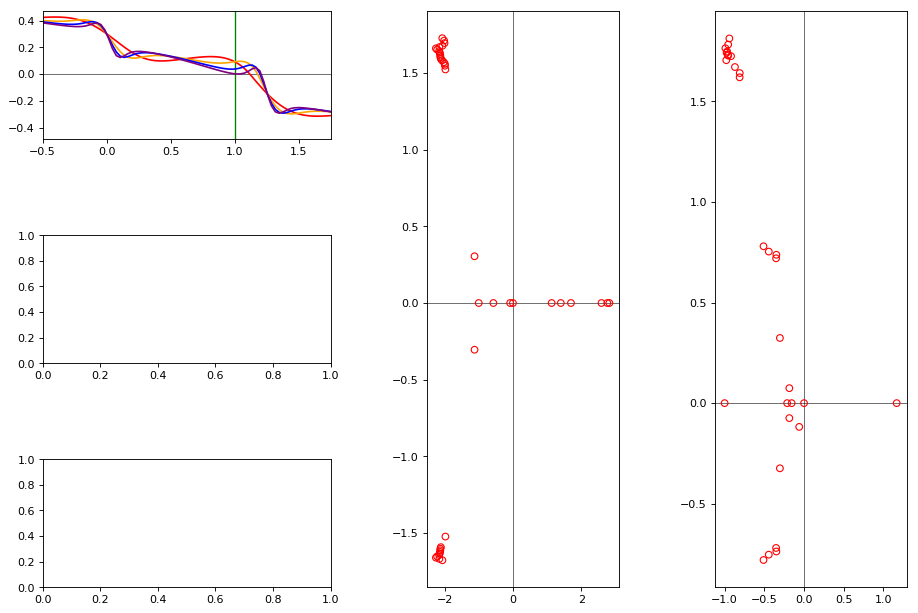

In [8]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Plot errors
ax[0].plot(freqarr, slog(errarr1), color=errcolor1, zorder=2)
ax[0].plot(freqarr, slog(errarr2), color=errcolor2, zorder=2)
ax[0].plot(freqarr, slog(errarr3), color=errcolor3, zorder=2)
ax[0].plot(freqarr, slog(errarr4), color=errcolor4, zorder=2)

# Eigenvalues
ax[3].scatter(found_eigs1.real, slog(found_eigs1.imag), facecolors='none', edgecolors='red', zorder=2)
ax[4].scatter(found_eigs2.real, slog(found_eigs2.imag), facecolors='none', edgecolors='red', zorder=2)

# Edit error plot
ax[0].set_xlim(left=w0-g, right=w0+g/2)
ax[0].axhline(y=0, linewidth=linewidthA, color=linecolorA, zorder=0)
ax[0].axvline(x=w0, linewidth=linewidthB, color=linecolorB, zorder=0)

# Axis lines
ax[3].axvline(x=0, color='black', linewidth=0.5, zorder=0)
ax[4].axvline(x=0, color='black', linewidth=0.5, zorder=0)
ax[3].axhline(y=0, color='black', linewidth=0.5, zorder=0)
ax[4].axhline(y=0, color='black', linewidth=0.5, zorder=0)


## Figure part 1 statistics

In [9]:
print(f'Plotted deltas for fig.A: \n \
      {errcolor1}: {delta1} \n \
      {errcolor2}: {delta2} \n \
      {errcolor3}: {delta3} \n \
      {errcolor4}: {delta4}')

print(f'Plotted deltas for fig.B, C: \n \
      delta B: {delta_plot1} \n \
      Omega B: {Omega_plot1} \n \
      delta C: {delta_plot2} \n \
      Omega C: {Omega_plot2}')

Plotted deltas for fig.A: 
       red: 0.05 
       orange: 0.1 
       blue: 0.15 
       purple: 0.2
Plotted deltas for fig.B, C: 
       delta B: 0.03 
       Omega B: 0.5085937499999995 
       delta C: 0.1 
       Omega C: 0.8487304687499998


## Generate figures part 2

## Options

In [10]:
# Part 2
bbox5 = [0.1, 0.1, 0.4, 0.9]
bbox6 = [0.6, 0.1, 0.4, 0.9]

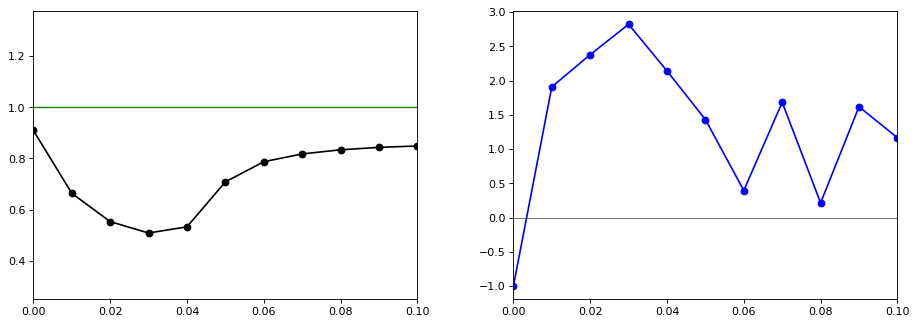

In [11]:
fig, ax = plt.subplots(2, figsize=(12,4), dpi=80)

# Set positions
ax[0].set_position(bbox5)
ax[1].set_position(bbox6)

ax[0].plot(deltaarr, Omegaarr, marker='o', color='black')
ax[1].plot(deltaarr, leadreeigs, marker='o', color='blue')

# Set limits
ax[0].set_xlim(left=0, right=np.max(deltaarr))
ax[0].set_ylim(bottom=w0-g/2, top=w0+g/4)
ax[1].set_xlim(left=0, right=np.max(deltaarr))

# Horizontal lines
ax[0].axhline(y=w0, linewidth=linewidthB, color=linecolorB, zorder=0)
ax[1].axhline(y=0, linewidth=linewidthA, color=linecolorA, zorder=0)

In [12]:
0.2*(1 - 2/pi)

0.07267604552648373